# Capstone Step 8 (20.5.1): Deep Learning Prototype

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
print(f'Tensorflow Version {tf.__version__}')

Tensorflow Version 2.9.0


## Data Preparation

I built a DL prototype with a binary outcome (i.e., whether or not a patient had been readmitted for the same reason). This model was relatively disappointing (accuracy = .77, precision = .19, recall = .43), so I am revising my approach. First, this DL prototype will have a multi-categorical outcome (i.e., no readmission, readmitted for the same reason, or readmitted for a different reason). Second, we will use the string variables that were omitted in the prior analyses and preprocess these variables using a TextVectorization layer. Third, we will simplify the primary diagnosis variable so that each patient is assigned to their parent diagnosis category. Hopefully these changes improve model performance.

I will continue employing some strategies from prior analyses (assigning class weights and transforming skewed continuous features). However, we are not going to over-sample the minority class in this analysis because (1) it wasn't effective at improving model fit and (2) because it is difficult to implement with string variables. However, we will experiment with under-sampling in this analysis to see if it can improve model performance. We are not going to fix the initial bias because this cannot be easily implemented in multiclass classification.

In [2]:
modeling_df = pd.read_csv(r'D:\MLE Capstone Project\Data\DL_data_prepared_multigroup.csv')

In [3]:
# We are going to test the code using a stratified sample of 16% of the data
# We will remove this filter once the code is working as intended
# modeling_df = modeling_df.groupby('Readmit', group_keys=False).apply(lambda x: x.sample(frac=0.16))

Given the relatively low classification metrics observed in the exploratory phase, I chose to transform some of the heavily skewed continuous variables (all of which were positively skewed).

In [4]:
# Transforming heavily positively skewed continuous variables
modeling_df['Log_TOTCHG'] = np.log(modeling_df.pop('TOTCHG') + 1)
modeling_df['Log_N_DISC_U'] = np.log(modeling_df.pop('N_DISC_U'))
modeling_df['Log_N_HOSP_U'] = np.log(modeling_df.pop('N_HOSP_U'))
modeling_df['Log_TOTAL_DISC'] = np.log(modeling_df.pop('TOTAL_DISC'))
modeling_df['Log_LOS'] = np.log(modeling_df.pop('LOS') + 1)
modeling_df['Log_I10_NPR'] = np.log(modeling_df.pop('I10_NPR') + 1)

In [5]:
# Encoding the primary diagnosis variable
encoder = OrdinalEncoder()
feature = modeling_df.pop('Primary_dx').to_numpy().reshape(-1, 1)
Primary_dx = encoder.fit_transform(feature)
modeling_df['Primary_dx'] = Primary_dx

In [6]:
# Changing dtypes to facilitate preprocessing in the next step
Secondary_dx = modeling_df.pop('Secondary_dx')
Procedure = modeling_df.pop('Procedure')
MBD_dx = modeling_df.pop('MBD_dx')
modeling_df = modeling_df.astype('float64')
modeling_df['Secondary_dx'] = Secondary_dx
modeling_df['Procedure'] = Procedure
modeling_df['MBD_dx'] = MBD_dx

In [7]:
# Creating training, validation, and test sets
train, valid, test = np.split(modeling_df.sample(frac=1), [int(0.8*len(modeling_df)), int(0.9*len(modeling_df))])
print(len(train), 'Training Examples')
print(len(valid), 'Validation Examples')
print(len(test), 'Test Examples')

502906 Training Examples
62863 Validation Examples
62864 Test Examples


Given that we have imbalanced classes, and that this imbalance may have contributed to the poor performance in the prior analyses, we are going to perform under-sampling using the RandomUnderSampler method to lessen the class imbalance. This could be performed while training our model using a BalancedBatchGenerator, but we will implement it into the data processing pipeline here so that we can estimate the correct bias and class weights later. If this is ineffective, we will remove the under-sampling component from the data processing pipeline.

In [8]:
# Performing under-sampling on the training data
y = train.pop('Readmit')
counter = Counter(y)
print(f'The original training data is shape {train.shape} and has {Counter(y)} samples per class.')
undersample = RandomUnderSampler(random_state=35, sampling_strategy={0.0:2*len(y[y != 0.0]),
                                                                     1.0:len(y[y == 1.0]),
                                                                     2.0:len(y[y == 2.0])})
train_us, y_us = undersample.fit_resample(train, y)
counter = Counter(y_us)
print(f'The undersampled training data is shape {train_us.shape} and has {Counter(y_us)} samples per class.')
# This seemed to be ineffective so I am not implementing it anymore below

The original training data is shape (502906, 31) and has Counter({0.0: 430521, 1.0: 46918, 2.0: 25467}) samples per class.
The undersampled training data is shape (217155, 31) and has Counter({0.0: 144770, 1.0: 46918, 2.0: 25467}) samples per class.


In [9]:
# Adding the y variables back into their respective dataframes
train['Readmit'] = y
train_us['Readmit'] = y_us

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502906 entries, 621882 to 353842
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   APRDRG                 502906 non-null  float64
 1   APRDRG_Risk_Mortality  502906 non-null  float64
 2   APRDRG_Severity        502906 non-null  float64
 3   HOSP_BEDSIZE           502906 non-null  float64
 4   H_CONTRL               502906 non-null  float64
 5   HOSP_URCAT4            502906 non-null  float64
 6   HOSP_UR_TEACH          502906 non-null  float64
 7   AGE                    502906 non-null  float64
 8   DIED                   502906 non-null  float64
 9   DISPUNIFORM            502906 non-null  float64
 10  DMONTH                 502906 non-null  float64
 11  ELECTIVE               502906 non-null  float64
 12  FEMALE                 502906 non-null  float64
 13  HCUP_ED                502906 non-null  float64
 14  I10_NDX                502906 n

## Data Preprocessing

The remaining data preprocessing will be conducted using Keras preprocessing layers.

In [11]:
# Defining a helper function that converts pd.DataFrame objects into tf.data.Dataset objects, shuffles the data, and batches it
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('Readmit')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [12]:
# Checking the format of the data that the dataframe_to_dataset helper function returns
# It returns a dictionary of column names that map to column values from rows
batch_size = 5
train_ds = dataframe_to_dataset(train, batch_size=batch_size)
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of diagnoses:', train_features['Primary_dx'])
print('A batch of targets:', label_batch)

Every feature: ['APRDRG', 'APRDRG_Risk_Mortality', 'APRDRG_Severity', 'HOSP_BEDSIZE', 'H_CONTRL', 'HOSP_URCAT4', 'HOSP_UR_TEACH', 'AGE', 'DIED', 'DISPUNIFORM', 'DMONTH', 'ELECTIVE', 'FEMALE', 'HCUP_ED', 'I10_NDX', 'PAY1', 'PL_NCHS', 'REHABTRANSFER', 'RESIDENT', 'SAMEDAYEVENT', 'ZIPINC_QRTL', 'Log_TOTCHG', 'Log_N_DISC_U', 'Log_N_HOSP_U', 'Log_TOTAL_DISC', 'Log_LOS', 'Log_I10_NPR', 'Primary_dx', 'Secondary_dx', 'Procedure', 'MBD_dx', 'Readmit']
A batch of diagnoses: tf.Tensor(
[[14.]
 [21.]
 [ 1.]
 [ 3.]
 [15.]], shape=(5, 1), dtype=float64)
A batch of targets: tf.Tensor([0. 0. 2. 0. 0.], shape=(5,), dtype=float64)


In [13]:
# Defining a utility function to apply feature-wise normalization to continuous features
def get_normalization_layer(name, dataset):
  normalizer = layers.Normalization(axis=None)
  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)
  return normalizer

In [14]:
# Testing the get_normalization_layer utility function
# This returns a Tensor layer with normalized values
LOS_col = train_features['Log_LOS']
test_layer = get_normalization_layer(name='Log_LOS', dataset=train_ds)
test_layer(LOS_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 1.2398367 ],
       [-0.8658569 ],
       [-0.1675897 ],
       [ 0.292347  ],
       [-0.47261322]], dtype=float32)>

In [15]:
# Defining a utility function to apply feature-wise multi-hot encoding to categorical features
# This function convert both strings and values to integer indices and then one hot encodes them
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)
  feature_ds = dataset.map(lambda x, y: x[name])
  index.adapt(feature_ds)
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  return lambda feature: encoder(index(feature))

In [16]:
# Testing the get_category_encoding_layer utility function
# This returns a Tensor layer with one hot encoded values
DX_col = train_features['Primary_dx']
test_layer = get_category_encoding_layer(name='Primary_dx',dataset=train_ds,dtype='float64')
test_layer(DX_col)

<tf.Tensor: shape=(5, 25), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [17]:
# Defining a utility function to apply feature-wise text vectorization to string variables
def get_vectorization_layer(name, dataset, output_mode='multi_hot'):
  vectorizer = layers.TextVectorization(output_mode=output_mode)
  feature_ds = dataset.map(lambda x, y: x[name])
  vectorizer.adapt(feature_ds)
  return vectorizer

In [18]:
# Testing the get_vectorization_layer utility function
# This returns a tensor layer with one hot encoded values
Procedure_col = train_features['Procedure']
test_layer = get_vectorization_layer(name='Procedure',dataset=train_ds)
test_layer(Procedure_col)

<tf.Tensor: shape=(5, 4788), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [19]:
# Creating the data input pipeline
batch_size = 512
train_ds = dataframe_to_dataset(train, batch_size=batch_size)
valid_ds = dataframe_to_dataset(valid, shuffle=False, batch_size=batch_size)
test_ds = dataframe_to_dataset(test, shuffle=False, batch_size=batch_size)

In [20]:
# Container for processed features
all_inputs = []
encoded_features = []

In [21]:
# Continuous feature preprocessing layer
continuous_features = ['APRDRG_Risk_Mortality','APRDRG_Severity','ZIPINC_QRTL','AGE','DMONTH','I10_NDX',
                       'Log_TOTCHG','Log_N_DISC_U','Log_N_HOSP_U','Log_TOTAL_DISC','Log_LOS','Log_I10_NPR']
for header in continuous_features:
  cont_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(name=header, dataset=train_ds)
  encoded_cont_col = normalization_layer(cont_col)
  all_inputs.append(cont_col)
  encoded_features.append(encoded_cont_col)

In [22]:
# Categorical feature preprocessing layer
categorical_features = ['APRDRG','HOSP_BEDSIZE','H_CONTRL','HOSP_URCAT4','HOSP_UR_TEACH','DIED','DISPUNIFORM','ELECTIVE',
                        'FEMALE','HCUP_ED','PAY1','PL_NCHS','REHABTRANSFER','RESIDENT','SAMEDAYEVENT','Primary_dx']
for header in categorical_features:
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='float64')
    encoding_layer = get_category_encoding_layer(name=header, dataset=train_ds, dtype='float64')
    encoded_cat_col = encoding_layer(cat_col)
    all_inputs.append(cat_col)
    encoded_features.append(encoded_cat_col)

In [23]:
# Text feature preprocessing layer
text_features = ['Secondary_dx','Procedure','MBD_dx']
for header in text_features:
    text_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    vectorization_layer = get_vectorization_layer(name=header, dataset=train_ds)
    encoded_text_col = vectorization_layer(text_col)
    all_inputs.append(text_col)
    encoded_features.append(encoded_text_col)

## Create, Complile, and Train the DNN

In [24]:
# tf.keras.backend.clear_session()

In [25]:
# Defining a function to create and compile a DNN
# Takes input, applies preprocessing layers, applies three hidden layers, and outputs probability per class
# Saves accuracy metric for multi-classification because nothing else works
my_metrics = [
    keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

def make_model(inputs=all_inputs, encodings=encoded_features, metrics=my_metrics, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)    
    
    all_features = tf.keras.layers.concatenate(encodings)
    Dense1 = tf.keras.layers.Dense(256, activation="relu", kernel_initializer="glorot_normal")(all_features)
    Norm1 = tf.keras.layers.BatchNormalization()(Dense1)
    Dropout1 = tf.keras.layers.Dropout(0.20)(Norm1)
    Dense2 = tf.keras.layers.Dense(128, activation="relu", kernel_initializer="glorot_normal")(Dropout1)
    Norm2 = tf.keras.layers.BatchNormalization()(Dense2)
    Dropout2 = tf.keras.layers.Dropout(0.20)(Norm2)
    Dense3 = tf.keras.layers.Dense(64, activation="relu", kernel_initializer="glorot_normal")(Dropout2)
    Norm3 = tf.keras.layers.BatchNormalization()(Dense3)
    Dropout3 = tf.keras.layers.Dropout(0.20)(Norm3)
    output = tf.keras.layers.Dense(3, activation='softmax', bias_initializer=output_bias)(Dropout3)

    model = tf.keras.Model(inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=metrics)

    return model

In [26]:
# Finding the correct class weights
w0, w1, w2 = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',
                                                             classes=np.unique(train['Readmit']),
                                                             y=train['Readmit'])
class_weights = {0:w0, 1:w1, 2:w2}
class_weights

{0: 0.3893778313562714, 1: 3.572942864856416, 2: 6.582453109252497}

In [27]:
# Defining an early stopping rule
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [28]:
# Fitting the model
model = make_model()
DNN_history = model.fit(
    train_ds, 
    batch_size=1024, 
    epochs=35,
    validation_data=valid_ds,
    class_weight=class_weights)

Epoch 1/50
983/983 [==============================] - 543s 530ms/step - loss: 1.0107 - accuracy: 0.4272 - val_loss: 0.9176 - val_accuracy: 0.5228
Epoch 2/50
983/983 [==============================] - 595s 590ms/step - loss: 0.9801 - accuracy: 0.4371 - val_loss: 1.0941 - val_accuracy: 0.3385
Epoch 3/50
983/983 [==============================] - 624s 620ms/step - loss: 0.9713 - accuracy: 0.4335 - val_loss: 0.9159 - val_accuracy: 0.5255
Epoch 4/50
983/983 [==============================] - 629s 624ms/step - loss: 0.9638 - accuracy: 0.4387 - val_loss: 1.0108 - val_accuracy: 0.4104
Epoch 5/50
983/983 [==============================] - 654s 647ms/step - loss: 0.9562 - accuracy: 0.4424 - val_loss: 1.0017 - val_accuracy: 0.4222
Epoch 6/50
983/983 [==============================] - 648s 640ms/step - loss: 0.9489 - accuracy: 0.4433 - val_loss: 1.0179 - val_accuracy: 0.4113
Epoch 7/50
983/983 [==============================] - 641s 636ms/step - loss: 0.9415 - accuracy: 0.4460 - val_loss: 1.0084 -

## Evaluate the Model

In [39]:
# Defining a function to visualize evaluation metrics on training and validation over epochs
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Validate')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0.4,1.2])
    else:
        plt.ylim([0.2,0.8])
    plt.xlim([1,50])
    plt.xticks(ticks=range(0,51,5))
    plt.legend();

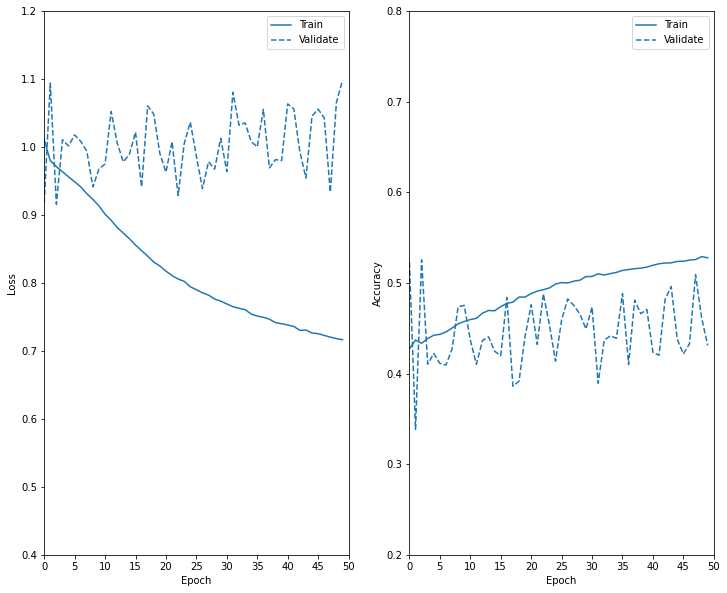

In [40]:
plot_metrics(DNN_history)

In [31]:
# Generating model prediction probabilities
train_predictions = model.predict(train_ds, batch_size=512)
validate_predictions = model.predict(valid_ds, batch_size=512)
test_predictions = model.predict(test_ds, batch_size=512)

123/123 [==============================] - 10s 82ms/step


In [32]:
# Generating model prediction classes
train_predict_class = np.argmax(train_predictions,axis=1)
validate_predict_class = np.argmax(validate_predictions,axis=1)
test_predict_class = np.argmax(test_predictions,axis=1)

In [33]:
# Defining a function to visualize the confusion matrix
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(10,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

  print('No Readmission (TN): ', cm[0][0])
  print('Readmission (TP): ', (cm[1][1] + cm[2][2]))
  print('Readmission Incorrectly Detected (FP): ', (cm[0][1] + cm[0][2]))
  print('Readmission Missed (FN): ', (cm[1][0] + cm[2][0]))
  print('Readmission Misclassified (FP/FN): ', (cm[2][1] + cm[1][2]))

loss :  1.1040445566177368
accuracy :  0.4288145899772644

No Readmission (TN):  22197
Readmission (TP):  4760
Readmission Incorrectly Detected (FP):  31638
Readmission Missed (FN):  1850
Readmission Misclassified (FP/FN):  2419


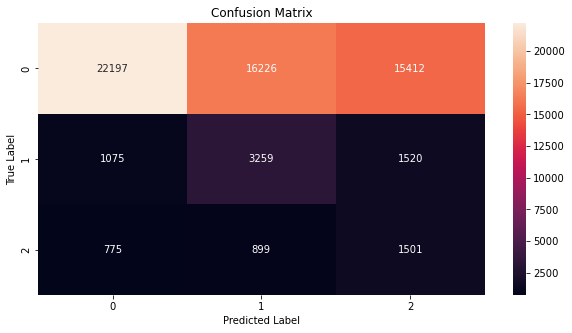

In [34]:
model_results = model.evaluate(test_ds, batch_size=512, verbose=0)
for name, value in zip(model.metrics_names, model_results):
  print(name, ': ', value)
print()
plot_cm(test['Readmit'], test_predict_class)

In [35]:
# Generating class-wise evaluation metrics
print(classification_report(test['Readmit'], test_predict_class))

              precision    recall  f1-score   support

         0.0       0.92      0.41      0.57     53835
         1.0       0.16      0.56      0.25      5854
         2.0       0.08      0.47      0.14      3175

    accuracy                           0.43     62864
   macro avg       0.39      0.48      0.32     62864
weighted avg       0.81      0.43      0.52     62864



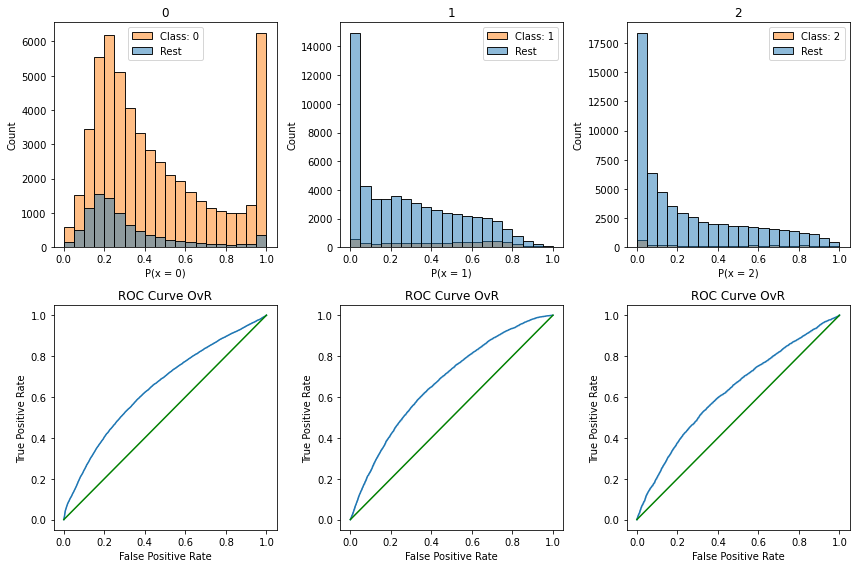

In [36]:
# Plotting one versus rest ROC curves
def calculate_tpr_fpr(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    tpr =  TP/(TP + FN)
    fpr = 1 - TN/(TN+FP)
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = [0,1,2]
roc_auc_ovr = {}
for i in range(len(classes)):
    c = classes[i]
    
    df_aux = test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in test['Readmit']]
    df_aux['prob'] = test_predictions[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [37]:
# Saving the model
model.save('D:\MLE Capstone Project\Model_V2')

INFO:tensorflow:Assets written to: D:\MLE Capstone Project\Model_V2\assets


INFO:tensorflow:Assets written to: D:\MLE Capstone Project\Model_V2\assets
